100.0%
100.0%
100.0%
100.0%



=== MNIST | device=cpu ===
Epoch 01/3 | train loss 0.1779 acc 0.9452 | test loss 0.0485 acc 0.9851
Epoch 02/3 | train loss 0.0557 acc 0.9823 | test loss 0.0331 acc 0.9899
Epoch 03/3 | train loss 0.0392 acc 0.9875 | test loss 0.0357 acc 0.9879


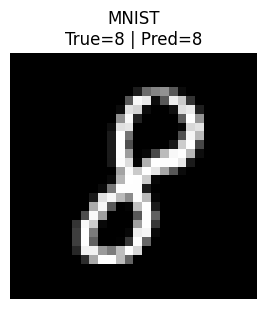

100.0%
100.0%
100.0%
100.0%



=== Fashion-MNIST | device=cpu ===
Epoch 01/3 | train loss 0.4036 acc 0.8547 | test loss 0.2855 acc 0.8954
Epoch 02/3 | train loss 0.2593 acc 0.9058 | test loss 0.2505 acc 0.9097
Epoch 03/3 | train loss 0.2115 acc 0.9228 | test loss 0.2247 acc 0.9180


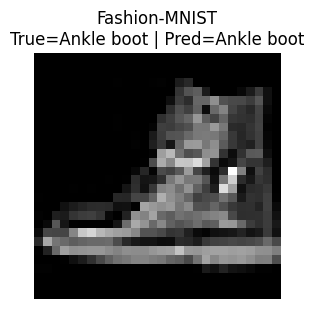

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
EPOCHS_MNIST = 3
EPOCHS_FASHION = 3
LR = 1e-3
SEED = 42

torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# -------------------------
# Modelo CNN (válido para ambos)
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.pool  = nn.MaxPool2d(2)                              # 28x28 -> 14x14
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# -------------------------
# Helpers: train / eval
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def show_one_prediction(model, dataset, title, class_names=None):
    model.eval()
    idx = torch.randint(0, len(dataset), (1,)).item()
    x, y = dataset[idx]
    x_batch = x.unsqueeze(0).to(DEVICE)

    logits = model(x_batch)
    pred = logits.argmax(dim=1).item()

    # Plot
    plt.figure(figsize=(3.2, 3.2))
    plt.imshow(x.squeeze(0), cmap="gray")
    plt.axis("off")

    if class_names is None:
        plt.title(f"{title}\nTrue={y} | Pred={pred}")
    else:
        plt.title(f"{title}\nTrue={class_names[y]} | Pred={class_names[pred]}")
    plt.show()


def run_experiment(dataset_name: str, epochs: int, class_names=None):
    # Normalización típica para MNIST/Fashion-MNIST
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    if dataset_name.lower() == "mnist":
        train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
        test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
        title = "MNIST"
    elif dataset_name.lower() in ["fashion", "fashion-mnist", "fashionmnist"]:
        train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tfm)
        test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tfm)
        title = "Fashion-MNIST"
    else:
        raise ValueError("dataset_name debe ser 'mnist' o 'fashion-mnist'.")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=(DEVICE=="cuda"))
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=(DEVICE=="cuda"))

    model = SimpleCNN(num_classes=10).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    print(f"\n=== {title} | device={DEVICE} ===")
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        te_loss, te_acc = evaluate(model, test_loader, criterion)
        print(f"Epoch {ep:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

    show_one_prediction(model, test_ds, title=title, class_names=class_names)
    return model


# -------------------------
# 1) MNIST
# -------------------------
mnist_model = run_experiment("mnist", epochs=EPOCHS_MNIST)

# -------------------------
# 2) Fashion-MNIST
# -------------------------
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
fashion_model = run_experiment("fashion-mnist", epochs=EPOCHS_FASHION, class_names=fashion_labels)
